In [1]:
%%capture
!wget https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train.csv
!wget https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/test.csv
!wget https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip
!unzip train_test_data.zip

In [2]:
import os, shutil, json
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers, Sequential
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
    Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Embedding, Concatenate)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler)
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score
)
from keras.wrappers.scikit_learn import KerasClassifier
from geopy.geocoders import Nominatim

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.sample(5)

,label,latitude,longitude,year,example_path
1491,2,1.379951,109.173739,2015,train_test_data/train/910.png
403,0,-0.153756,101.710400,2013,train_test_data/train/1197.png
1349,1,1.564307,101.082627,2012,train_test_data/train/2257.png
1532,2,1.883162,100.630087,2010,train_test_data/train/2026.png
952,0,1.451563,98.821693,2012,train_test_data/train/1684.png


In [4]:
os.makedirs("data/train/Plantation")
os.makedirs("data/train/Grassland_Shrubland")
os.makedirs("data/train/Smallholder_Agriculture")

os.makedirs("data/test/Plantation")
os.makedirs("data/test/Grassland_Shrubland")
os.makedirs("data/test/Smallholder_Agriculture")

In [5]:
for index, row in df_train.iterrows():
  if row["label"] == 0:
    shutil.move(row["example_path"], "data/train/Plantation/"+row["example_path"].split("/")[-1])
  elif row["label"] == 1:
    shutil.move(row["example_path"], "data/train/Grassland_Shrubland/"+row["example_path"].split("/")[-1])
  else:
    shutil.move(row["example_path"], "data/train/Smallholder_Agriculture/"+row["example_path"].split("/")[-1])

In [6]:
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = image_generator.flow_from_directory(
    "data/train", batch_size=50, shuffle=True,
    target_size=(256, 256), class_mode="categorical", subset="training"
)

test_generator = image_generator.flow_from_directory(
    "data/train", batch_size=50, shuffle=True,
    target_size=(256, 256), class_mode="categorical", subset="validation"
)

Found 1372 images belonging to 3 classes.
Found 342 images belonging to 3 classes.


In [7]:
train_images, train_labels = next(train_generator)

In [8]:
label_names = {
    0:"Plantation", 
    1:"Grassland_Shrubland", 
    2:"Smallholder_Agriculture",
}

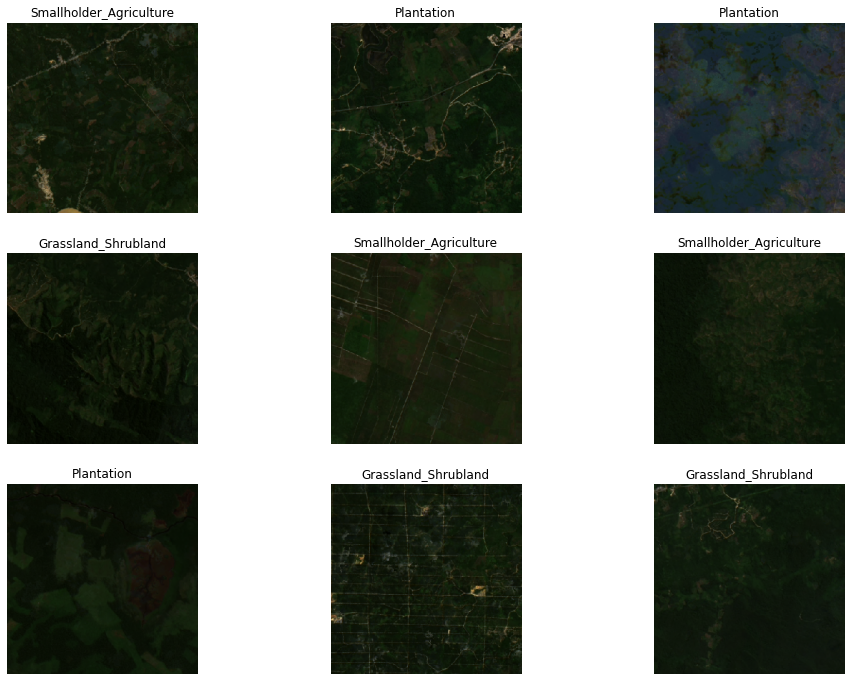

In [9]:
L, W = 3, 3

fig, axes = plt.subplots(L, W, figsize=(15,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.7)

In [10]:
from tensorflow.keras.applications import InceptionResNetV2
basemodel = InceptionResNetV2(
    weights="imagenet",
    include_top=False, 
    input_tensor=Input(shape=(256, 256, 3))
)

219055592/219055592 [==============================] - 6s 0us/step


In [11]:
for layer in basemodel.layers[:-100]:
  layer.trainable = False

In [14]:
headmodel = basemodel.output
headmodel = Conv2D(64,(3,3),activation='relu', padding='same')(headmodel)
headmodel = Dropout(0.20)(headmodel)
headmodel = Conv2D(64, (3,3), activation = 'relu')(headmodel)
headmodel = AveragePooling2D((4, 4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.30)(headmodel)
headmodel = Dense(3, activation="softmax")(headmodel)
model = Model(inputs = basemodel.input, outputs=headmodel)

In [15]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=[f1_m]
)

In [16]:
earlystopping = EarlyStopping(
    monitor="val_f1_m", mode="auto", verbose=1, patience=6)

checkpointer = ModelCheckpoint(
    filepath="weights.hdf5", verbose=1, save_best_only=True)

In [17]:
train_generator = image_generator.flow_from_directory(
    "data/train",
    batch_size=4,
    shuffle=True,
    target_size=(256,256),
    class_mode="categorical",
    subset="training"
)

val_generator = image_generator.flow_from_directory(
    "data/train",
    batch_size=4,
    shuffle=True,
    target_size=(256,256),
    class_mode="categorical",
    subset="validation"
)

Found 1372 images belonging to 3 classes.
Found 342 images belonging to 3 classes.


In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//4,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_generator.n//4,
                    callbacks=[checkpointer, earlystopping])

Epoch 1/30
343/343 [==============================] - ETA: 0s - loss: 0.9841 - f1_m: 0.3618
Epoch 1: val_loss improved from inf to 0.90274, saving model to weights.hdf5
343/343 [==============================] - 54s 95ms/step - loss: 0.9841 - f1_m: 0.3618 - val_loss: 0.9027 - val_f1_m: 0.3974
Epoch 2/30
343/343 [==============================] - ETA: 0s - loss: 0.8578 - f1_m: 0.5174
Epoch 2: val_loss improved from 0.90274 to 0.80047, saving model to weights.hdf5
343/343 [==============================] - 30s 86ms/step - loss: 0.8578 - f1_m: 0.5174 - val_loss: 0.8005 - val_f1_m: 0.4919
Epoch 3/30
343/343 [==============================] - ETA: 0s - loss: 0.7588 - f1_m: 0.6373
Epoch 3: val_loss improved from 0.80047 to 0.72576, saving model to weights.hdf5
343/343 [==============================] - 29s 83ms/step - loss: 0.7588 - f1_m: 0.6373 - val_loss: 0.7258 - val_f1_m: 0.6795
Epoch 4/30
343/343 [==============================] - ETA: 0s - loss: 0.7379 - f1_m: 0.6686
Epoch 4: val_loss 

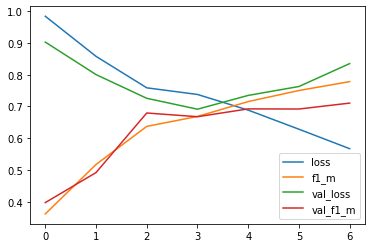

In [19]:
pd.DataFrame(history.history).plot();

In [20]:
evaluate = model.evaluate(
    val_generator, 
    steps=val_generator.n//4,
    verbose=1
)
print(f"Precision en la fase Test: {evaluate[1]}")

85/85 [==============================] - 5s 58ms/step - loss: 0.8363 - f1_m: 0.7080
Precision en la fase Test: 0.7079831957817078


1/1 [==============================] - 4s 4s/step
Grassland_Shrubland


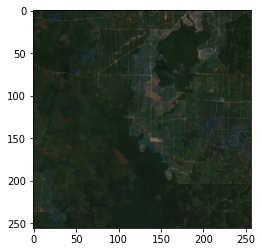

In [21]:
img = tensorflow.keras.preprocessing.image.load_img("train_test_data/test/333.png",
                                    target_size=(256, 256))
imga = tensorflow.keras.preprocessing.image.img_to_array(img)
imga = tensorflow.expand_dims(imga,0)
imga = imga/255
y = model.predict(imga)
print(label_names[np.argmax(y)])
plt.imshow(img);

In [22]:
scores = []
for img_test in os.listdir("train_test_data/test/"):
  img = tensorflow.keras.preprocessing.image.load_img("train_test_data/test/"+img_test, target_size=(256, 256))
  imga = tensorflow.keras.preprocessing.image.img_to_array(img)
  imga = tensorflow.expand_dims(imga,0)
  imga = imga/255
  y = model.predict(imga, verbose=0)
  scores.append(np.argmax(y))
df_test["target"] = scores
df_test.head()

,latitude,longitude,year,example_path,target
0,0.761681,122.755954,2006,train_test_data/test/69.png,2
1,-8.059785,113.053791,2007,train_test_data/test/469.png,1
2,-2.006610,111.746316,2002,train_test_data/test/6.png,2
3,0.901765,114.042495,2016,train_test_data/test/351.png,2
4,1.911210,100.829633,2008,train_test_data/test/1001.png,1


In [23]:
json_str = df_test.target.to_json()

with open('predictions.json', 'w') as f:
  dic = json.loads(json_str)
  json.dump({'target':dic}, f)